# 实施 HKS
本笔记本演示了如何使用 heat_kernel_signature.py 中的函数。


安装所需要的包

In [ ]:
!pip install tensorflow_graphics
!pip install trimesh

!pip install Open3d

import模块

In [3]:
import numpy as np
import tensorflow as tf
# import tensorflow_graphics as tfg
import trimesh

import heat_kernel_signature as hks

## `heat_kernel_signature` 模块

导入库和 `heat_kernel_signature` 模块后，下面两个示例将展示函数的用法。

模块中有三个主要函数值得注意：
* `heat_kernel(vertices,x,t)`： 该函数计算某一特定时刻 $t$ 下的某一顶点 $x$ 遍历模型内每个点 $y$ 的热核 $k_t(x,y)$。其结果是一个向量。

* `hks_t(vertices, t)`： 此函数计算在时间为 $t$ 时模型上每个顶点 $x$ 的热核描述子 $k_t(x,x)$。其结果也是一个向量。

* `HKS(vertices, ts)`： 该函数在多个时间刻度 $t$ 下计算模型上每个顶点 $x$ 的热核描述子 $k_t(x,x)$。计算结果是一个矩阵，每列代表一个时间刻度 $t$，每行代表一个顶点的 hks。


## Eg 1: Cow

我们首先使用 trimesh 加载一个奶牛网格。可以看到，奶牛网格有 1251 个顶点。

In [4]:
cow = trimesh.load('cow.obj')

In [7]:
print("Number of vertices: ", len(cow.vertices)) 

Number of vertices:  1251


我们可以通过观察几对相邻顶点之间的距离来判断需要考虑的 $t$ 的适当范围。这一步是可选的。

In [8]:
for i in range(10):
    print(np.linalg.norm(cow.vertices[i] - cow.vertices[cow.vertex_neighbors[i][0]]))

0.19846183611465473
0.349696314564509
0.49674462298951966
0.17673287271472732
0.21170698573500116
0.23859173592771402
0.20491859795782322
0.17502020234532928
0.24860618508999333
0.1909508848814269


###  计算热核
使用函数 `heat_kernel(vertices, x, t)` 来计算某一时刻 $t$ 下某个顶点的热核（注意热核是遍历模型上所有点的）

In [9]:
cow_vertices = cow.vertices

In [10]:
vertex = 257
t = 0.5

In [11]:
HK_cow = hks.heat_kernel(cow_vertices, vertex, t)
HK_cow

<tf.Tensor: shape=(1251,), dtype=float64, numpy=
array([1.11866641e-07, 6.41079582e-06, 6.19890238e-06, ...,
       3.40806145e-08, 2.93484340e-08, 3.29532728e-08])>

可视化网格上的 HK

注：

1.函数 trimesh.visual.color.interpolate(values, color_map=None, dtype=<class'numpy.uint8'>)

给定一维数值列表（本实验为某一时刻t下各个点的hks值），返回该范围内的插值颜色。

参数：

values （（n， ） float）- 要做颜色插值的一维数值列表

color_map （None，或 str）- 色谱图的关键字，该色谱图包含在： matplotlib.pyplot.colormaps() 中，例如： 'viridis' 。

返回：
interpolated - 插值 RGBA 颜色

返回类型：
(n, 4) dtype

2.函数trimish.visual.vertex_colors

In [25]:
cow.visual.vertex_colors = trimesh.visual.color.interpolate(HK_cow, "jet")
print("t = ", t)
cow.show(height = 200)

t =  1.0


### 计算热核描述子(HKS)
利用HKS函数计算模型的热核描述子矩阵，矩阵的每一列代表每个采样的时间 $t$ ，每行代表模型的每个顶点

In [31]:
ts = [0.5, 0.8]

In [35]:
HKS_cow = hks.HKS(cow_vertices, ts)

可视化网格上的 HKS

In [20]:
cow.visual.vertex_colors = trimesh.visual.color.interpolate(HKS_cow[:, 0], "jet")
print("t = ", ts[0])
cow.show(height = 200)

t =  0.3


In [21]:
cow.visual.vertex_colors = trimesh.visual.color.interpolate(HKS_cow[:, 1], "jet")
print("t = ", ts[1])
cow.show(height = 200)

t =  0.3878787878787879


增加某一时刻

我们还可以使用函数 `hks_t(vertices,t)`，计算所有顶点在某一时刻 $t$ 的热核特征。计算出的向量还可以与之前使用`HKS(vertices, ts)`计算出的热核特征矩阵进行连接。

In [2]:
t = 1.0
np.append(ts,t)
HKS_cow = tf.concat([HKS_cow, tf.reshape(hks.hks_t(cow_vertices, t), shape=[-1, 1])], axis=1)

NameError: name 'np' is not defined

In [27]:
tf.shape(HKS_cow)

<tf.Tensor: shape=(2,), dtype=int32, numpy=array([1251,    3])>

In [1]:
ts.shape

NameError: name 'ts' is not defined

In [24]:
cow.visual.vertex_colors = trimesh.visual.color.interpolate(HKS_cow[:, 2], "jet")
print("t = ", ts[2])
cow.show(height = 200)

InvalidArgumentError: {{function_node __wrapped__StridedSlice_device_/job:localhost/replica:0/task:0/device:CPU:0}} slice index 2 of dimension 1 out of bounds. [Op:StridedSlice] name: strided_slice/

### Plotting HKS of vertices across time scales
One way to see how the similarity between different vertices evolve across multiple scales is by plotting the HKS of different vertices across multiple time scales.

We will first import matplotlib.

In [18]:
import matplotlib.pyplot as plt

We will now compute the HKS using `hks.HKS(vertices, ts)` across multiple time scales. Note that this might take some time to compute if the number of time scales considered is high.

In [19]:
ts = np.linspace(0.3, 9.0, 100)

In [23]:
# This might take a while
HKS_cow = hks.HKS(cow_vertices, ts)

We will define a normalise function here since we are using it again later for the second example (Eg 2: Homer)

In [24]:
def normalise(mat):
    """Minmax normalises a matrix columnwise."""
    max = tf.math.reduce_max(mat, axis=0)
    min = tf.math.reduce_min(mat, axis=0)
    n_mat = tf.math.truediv((mat - min), (max - min))

    return n_mat

In [25]:
HKS_cow_n = normalise(HKS_cow)

We are now going to select a few notable vertices to observe their HKS across different time scales.

* 881: left horn
* 1060: right horn
* 433: front right foot
* 802：rear left foot
* 800: front belly
* 1000: left side of body

The following plot shows the scaled HKS of each vertex against time in logarithmic scale (log t). The mesh of the cow is annotated with the vertices in their respective plot colours.

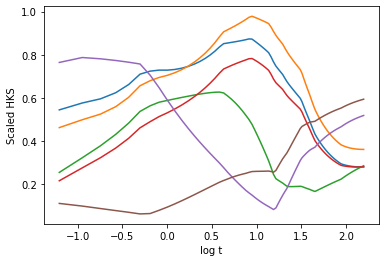

In [26]:
vertices = [881, 1060, 433, 802, 1000, 800]
colours = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']
cow.visual.vertex_colors = [255, 255, 255, 255]
log_ts = np.log(ts)
for i in range(len(vertices)):
    cow.visual.vertex_colors[vertices[i]] = trimesh.visual.color.hex_to_rgba(colours[i])
    plt.plot(log_ts, HKS_cow_n[vertices[i]], colours[i], label = "{}".format(vertices[i]))
# plt.legend()
plt.ylabel("Scaled HKS")
plt.xlabel("log t")
plt.show()
cow.show(height = 200)

## Eg 2: Homer

This second example is essentially the same thing, demonstrating the use of the `HKS(vertices, ts)` function.

In [27]:
homer = trimesh.load('homer4k.obj')
print("Number of vertices: ", len(homer.vertices))

Number of vertices:  4002


Note that the mesh has around 4000 vertices, which is a lot, so it takes some time for eigen decomposition when computing the heat kernel signatures.

In [28]:
for i in range(10):
    print(np.linalg.norm(homer.vertices[i] - homer.vertices[homer.vertex_neighbors[i][0]]))

0.06378465487090136
0.0151718272465778
0.012859951555118699
0.016301243694884147
0.01143949623016678
0.013933511151177955
0.022535541462321246
0.011352652069010146
0.015916118810815665
0.016255829631243068


### Computing the Heat Kernel Signature (HKS)

In [29]:
homer_vertices = homer.vertices

In [30]:
ts = [0.01, 0.03, 0.09]

In [31]:
# This will take a while
HKS_homer = hks.HKS(homer_vertices, ts)
tf.shape(HKS_homer)

<tf.Tensor: shape=(2,), dtype=int32, numpy=array([4002,    3], dtype=int32)>

Visualising the HKS on the mesh

In [32]:
homer.visual.vertex_colors = trimesh.visual.color.interpolate(HKS_homer[:, 0], "jet")
print("t = ", ts[0])
homer.show(height = 300)

t =  0.01


In [33]:
homer.visual.vertex_colors = trimesh.visual.color.interpolate(HKS_homer[:, 1], "jet")
print("t = ", ts[1])
homer.show(height = 300)

t =  0.03


In [34]:
homer.visual.vertex_colors = trimesh.visual.color.interpolate(HKS_homer[:, 2], "jet")
print("t = ", ts[2])
homer.show(height = 300)

t =  0.09


### Plotting HKS of vertices across time scales
One way to see how the similarity between different vertices evolve across multiple scales is by plotting the HKS of different vertices across multiple time scales.

The original Homer mesh imported has over 4k vertices. It will simply take too much time to compute the HKS across many time scales. Therefore, we can first simplify the mesh. `Trimesh` currently does not support mesh simplification so we are going to use `open3d` to do the job. `open3d` is pip installed at the start of the notebook. We are going to import it now.

In [35]:
import open3d as o3d

In [36]:
homer_og = o3d.io.read_triangle_mesh("homer4k.obj")

In [37]:
homer_sim = homer_og.simplify_quadric_decimation(
    target_number_of_triangles=3000)
homer_sim = trimesh.base.Trimesh(vertices=np.asarray(homer_sim.vertices), faces=np.asarray(homer_sim.triangles))
print(homer_sim)

<trimesh.Trimesh(vertices.shape=(1502, 3), faces.shape=(3000, 3))>


After mesh simplification, the simplified homer mesh has 1502 vertices. We check to see if there is any significant degradation in the shape before moving on. As can be seen, there is not a lot of degradation apart from near the feet, so that is good.

In [38]:
homer_sim.show(height=300)

We will now compute the HKS using `hks.HKS(vertices, ts)` across multiple time scales. Note that this might take some time to compute if the number of time scales considered is high despite the simplified mesh.

In [39]:
ts = np.linspace(0.01, 1.0, 100)
homer_vertices = homer_sim.vertices

In [40]:
HKS_homer_sim = hks.HKS(homer_vertices, ts)

In [41]:
HKS_homer_n = normalise(HKS_homer_sim)

We are now going to select a few notable vertices to observe their HKS across different time scales.

* 799: left big toe
* 615: right big toe
* 1236: right butt
* 149: left butt
* 650: in mouth
* 404: top of head

The following plot shows the scaled HKS of each vertex against time in logarithmic scale (log t). The Homer mesh is annotated with the vertices in their respective plot colours.

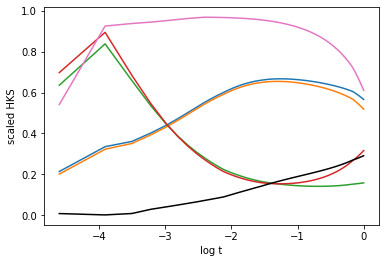

In [43]:
vertices = [799, 615, 1236, 149, 650, 404]
colours = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#000000', '#e377c2']
homer_sim.visual.vertex_colors = [255, 255, 255, 255]
log_ts = np.log(ts)
for i in range(len(vertices)):
    homer_sim.visual.vertex_colors[vertices[i]] = trimesh.visual.color.hex_to_rgba(colours[i])
    plt.plot(log_ts, HKS_homer_n[vertices[i]], colours[i], label = "{}".format(vertices[i]))
# plt.legend()
plt.xlabel("log t")
plt.ylabel("scaled HKS")
plt.show()
homer_sim.show(height = 400)